In [4]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

In [7]:
from keras_spatial import SpatialDataGenerator

raster_dem = 'test.tif'
sdg = SpatialDataGenerator(source=raster_dem)
print(sdg.src.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 647, 'height': 1621, 'count': 5, 'crs': CRS.from_wkt('PROJCS["EQUIRECTANGULAR Moon",GEOGCS["GCS_Moon",DATUM["D_Moon",SPHEROID["Moon_localRadius",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(195.90939498911, 0.0, 865527.7070618877,
       0.0, -195.90939498911, 726040.217829671)}


Created490 samples


,geometry
0,"POLYGON ((874527.707 408471.089, 874527.707 41..."
1,"POLYGON ((883585.659 408471.089, 883585.659 41..."
2,"POLYGON ((892643.611 408471.089, 892643.611 41..."
3,"POLYGON ((901701.564 408471.089, 901701.564 41..."
4,"POLYGON ((910759.516 408471.089, 910759.516 41..."


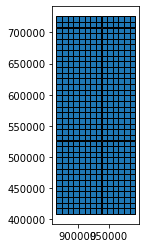

In [25]:
df = sdg.regular_grid(9000, 9000)

print(f'Created{len(df)} samples')
df.plot(color=None, edgecolor='k')
df.head()


Created 490 samples


<AxesSubplot:>

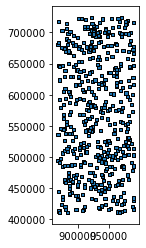

In [26]:
df_rand = sdg.random_grid(5000, 5000, 490)
print(f'Created {len(df_rand)} samples')
df_rand.plot(color=None, edgecolor='k')

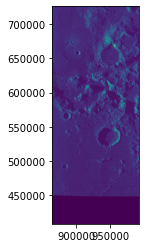

<AxesSubplot:>

In [28]:
dem_path = 'test.tif'
dem = SpatialDataGenerator(source=dem_path)
show(dem.src)

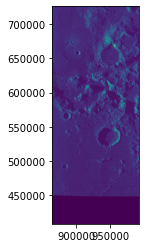

<AxesSubplot:>

In [29]:
label_path = 'test.tif'
labels = SpatialDataGenerator(source=label_path)
show(labels.src)

In [30]:
# Selecting samples within an area of interest
# watershed_path = './data/watershed.geojson'
# mask = gpd.read_file(watershed_path)
# mask.plot()

In [31]:
# samples = df[df.intersects(mask.unary_union)].copy()
# samples.plot(color=None, edgecolor='k')

In [ ]:
# define label raster as a source raster
label_path = './data/label.tiff'
lsdg = SpatialDataGenerator(source=label_path)
width, height = 128, 128
samples['features'] = [(np.sum(np.where(arr==1, 0, arr) ))
for arr in lsdg.flow_from_dataframe (samples, width, height,
samples.plot(column='features', legend=True)
samples.head(5)

In [ ]:
dem_path = './data/raster.tiff'
rsdg = SpatialDataGenerator(dem_path)
samples['elevation'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (sample
samples.plot(column='elevation', legend=True)

In [ ]:
samples['maxelv'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (samples,
samples['minelv'] = [(np.min(np.where(arr>0, arr, np.nan))) for arr in rsdg.flow_
print(samples.maxelv.max(), samples.minelv.min())

In [ ]:
def normalize(arr, gmin, gmax):
return (arr - gmin) / (gmax - gmin)
sdg.add_preprocess_callback('elvnorm', normalize, samples.minelv.min(), samples.m
gen = sdg.flow_from_dataframe(samples, 128, 128, batch_size=1)
arr = next(gen)
imgplot = plt.imshow(arr[0, :, :, 0], cmap='viridis')
plt.colorbar()

In [ ]:
# example of Feeding samples to a DL model
width, height = 128, 128
train_gen = zip(labels.flow_from_dataframe(df, width, height), dem.flow_from_data